<a href="https://colab.research.google.com/github/ujeongmin/ESAA/blob/main/ESAA_HW_3_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## [3. 분류]
### 3.1 MNIST
미국 인구조사국 직원들이 손으로 쓴 70,000개의 작은 숫자 이미지를 모은 데이터셋

In [5]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

* 데이터셋을 설명하는 DESCR 키
* 샘플이 하나의 행, 특성이 하나의 열로 구성된 배열을 가진 data 키
* 레이블 배열을 담은 target 키

In [6]:
X, y = mnist['data'], mnist['target']
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


* 이미지가 28x28, 각 이미지에는 784개의 특성
* 개개의 특성은 0(흰색)부터 255(검은색)까지의 픽셀 강도를 나타냄

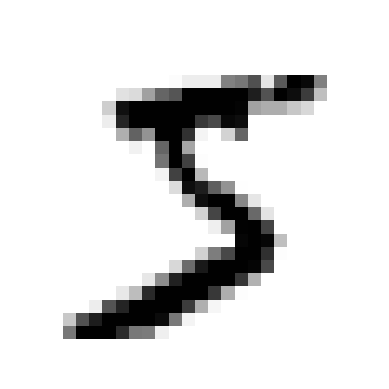

In [7]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [8]:
y[0]

'5'

* 그림은 숫자 5로 보임, 실제 레이블도 5, y를 정수로 변환

In [10]:
import numpy as np
y = y.astype(np.uint8)

* 앞 60,000개를 훈련 세트, 뒤 10,000개를 테스트 세트로 나누기

In [11]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### 3.2 이진 분류기 훈련

숫자 5만 식별해보기: '5-감지기'는 '5'와 '5 아님' 두 개의 클래스를 구분할 수 있는 이진 분류기의 한 예

In [12]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

* 사이킷런의 SGDClassifier 클래스를 사용해 확률적 경사 하강법(SGD) 분류기 사용
* 매우 큰 데이터셋을 효율적으로 처리하는 장점, 한 번에 하나씩 훈련 샘플을 독립적으로 처리하기 때문

In [13]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [15]:
sgd_clf.predict([some_digit])

array([ True])

* 분류기가 이 이미지가 5를 나타낸다고 추측함

### 3.3 성능 측정
#### 3.3.1 교차 검증을 사용한 정확도 측정


* 다음 코드는 사이킷런의 cross_val_score() 함수와 거의 같은 작업을 수행하고 동일한 결과를 출력

In [17]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3)

for train_index, test_index in skfolds.split(X_train, y_train_5):
  clone_clf = clone(sgd_clf)
  X_train_folds = X_train[train_index]
  y_train_folds = y_train_5[train_index]
  X_test_fold = X_train[test_index]
  y_test_fold = y_train_5[test_index]

  clone_clf.fit(X_train_folds, y_train_folds)
  y_pred = clone_clf.predict(X_test_fold)
  n_correct = sum(y_pred == y_test_fold)
  print(n_correct / len(y_pred))

0.95035
0.96035
0.9604


In [18]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

* 모든 이미지를 '5 아님' 클래스로 분류하는 더미 분류기 만들어 비교

In [19]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
  def fit(self, X, y=None):
    return self
  def predict(self, X):
    return(np.zeros((len(X), 1), dtype=bool))

In [20]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

* 이미지의 10% 정도만 숫자 5이기 때문에 무조건 '5 아님'으로 예측하면 정확히 맞출 확률이 90%

즉 정확도를 분류기의 성능 측정 지표로 선호하지 않는 이유임  
특히 불균형한 데이터셋을 다룰 때 더욱

#### 3.3.2 오차 행렬
분류기가 숫자 5의 이미지를 3으로 잘못 분류한 횟수를 알고 싶다면 오차 행렬의 5행 3열을 보면 됨  
실제 타깃과 비교할 수 있도록 먼저 예측값을 만들기


In [21]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [23]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

* 행은 실제 클래스, 열은 예측한 클래스를 나타냄
* 첫번째 행은 음성 클래스, 진짜 음성, 거짓 양성
* 두번째 행은 양성 클래스, 거짓 음성, 진짜 양성

In [26]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

#### 3.3.3 정밀도와 재현율
정밀도 = TP/TP+FP, 재현율 = TP/TP+FN

In [28]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [29]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

* 정밀도와 재현율을 F1 Score라는 하나의 숫자로 만들면 편리

In [30]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

#### 3.3.4 정밀도/재현율 트레이드오프
* 이 둘을 모두 얻을 수는 없음

In [32]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [34]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

* 임곗값이 0이므로 위 코드는 predict() 메서드와 같은 결과를 반환

In [35]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

* 임곗값을 높이면 재현율이 줄어듬

적절한 임곗값을 정하려면 cross_val_predict()를 사용해 룬련 세트에 있는 모든 샘플의 점수를 구해야 함, 예측 결과가 아닌 결정 점수를 반환받도록 지정

In [36]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

* 이 점수로 precision_recall_curve() 함수를 사용하여 가능한 모든 임곗값에 대해 정밀도와 재현율 계산 가능

In [37]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

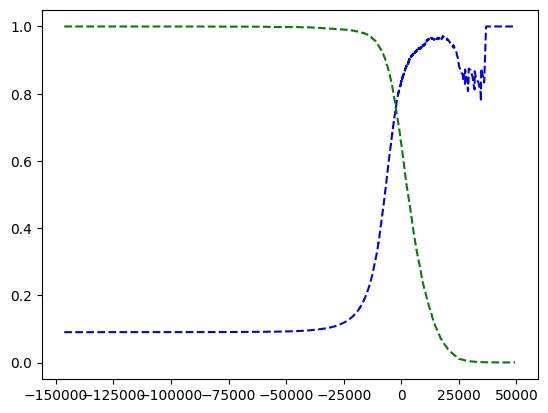

In [38]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], 'b--', label='정밀도')
  plt.plot(thresholds, recalls[:-1], 'g--', label='재현율')
  [...]

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

* 좋은 정밀도/재현율 트레이드오프를 선택하는 다른 방법은 재현율에 대한 정밀도 곡선을 그리는 것
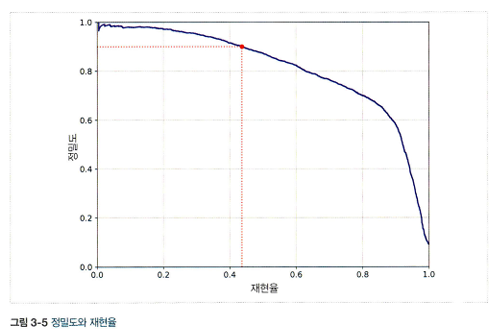

* 재현율 80% 근처에서 정밀도가 급격하기 줄어들기 시작하므로 이 하강점 직전을 트레이드오프로 선택하는 것이 좋음
* 정밀도 90%를 달성하는 것이 목표라면 임곗값이 약 8,000 정도 (curve 그림에서), 더 정확하게 찾으려면 아래 코드 사용

In [41]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

* 예측 만드는 코드

In [42]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

0.9000345901072293
0.4799852425751706


#### 3.3.5 ROC 곡선
수신기 조작 특성(ROC) 곡선도 이진 분류에서 널리 사용  
민감도(재현율)에 대한 1-특이도 그래프, TPR과 FPR 계산해야 함


In [43]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

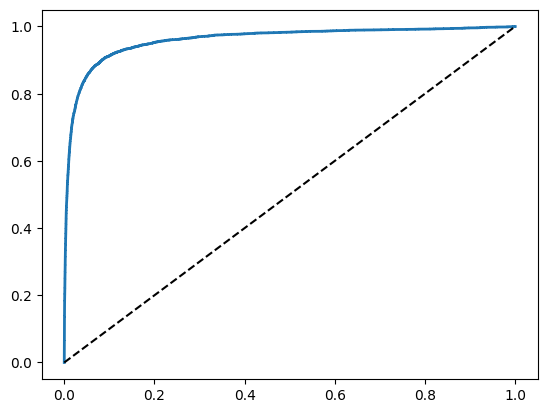

In [44]:
def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0,1],[0,1],'k--')
  [...]

plot_roc_curve(fpr, tpr)
plt.show()

* 좋은 분류기는 점선에서 최대한 멀리 떨어져있어야 함(왼쪽 위 모서리)
* 곡선 아래의 면적(AUC)를 측정하면 분류기들 비교 가능, 완벽한 분류기는 AUC가 1

In [45]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

* RandomForestClassifier로 SGDClassifier의 ROC 곡선과 ROC AUC 점수를 비교

In [47]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

In [48]:
y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

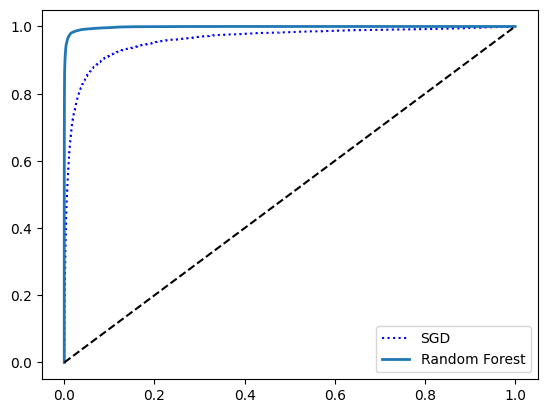

In [51]:
plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.legend(loc='lower right')
plt.show()

* RF 분류기가 SGD보다 그래프도 ROC AUC 점수도 훨씬 좋음

In [52]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

### 3.4 다중 분류
다중 분류기 또는 다항 분류기는 둘 이상의 클래스 구별 가능  

1) 이미지를 분류할 때 각 분류기의 결정 점수 중에서 가장 높은 것을 클래스로 선택함, 이를 OvR(one-versus-the-rest) 전략 또는 OvA(one-versus-all)라고 부름

2) 0과 1구별, 0과 2 구별 등과 같이 각 숫자의 조합마다 이진 분류기를 훈련시킴, 이를 OvO(one-versus-one) 전략이라고 부름

클래스가 N개라면 분류기는 N x (N-1) / 2개가 필요

In [53]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

* OvO 전략을 사용해 10개의 이진 분류기를 훈련시키고 각각의 결정 점수를 얻어 점수가 가장 높은 클래스 선택

In [55]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

* 가장 높은 점수가 클래스 5에 해당하는 값

In [56]:
print(np.argmax(some_digit_scores))
print(svm_clf.classes_)
print(svm_clf.classes_[5])

5
[0 1 2 3 4 5 6 7 8 9]
5


* OvO나 OvR을 사용하도록 강제하려면 OneVsOneClassifier나 OneVsRestClassifier을 사용하면 됨
* 다음은 OvR 전략을 사용하는 다중 분류기

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)

In [59]:
ovr_clf. predict([some_digit])

array([5], dtype=uint8)

In [58]:
len(ovr_clf.estimators_)

10

* SGD 또는 RF 분류기를 훈련시키는 것도 간단함

In [60]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

* 이 경우 SGD 분류기는 직접 샘플을 다중 클래스로 분류할 수 있기 때문에 별도로 사이킷런의 OvR이나 OvO를 적용할 필요가 없음

In [61]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

* 분류기가 예측 결과에 강한 확신을 보이고 있음 (대부분의 점수가 큰 음수)

In [62]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

* 스케일링을 통해 정확도 높이기 가능

In [63]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

### 3.5 에러 분석
가능성이 높은 모델을 하나 찾았다고 가정하고 이 모델의 성능을 향상시킬 방법을 찾아봄  
그 중 한 가지 방법이 만들어진 에러의 종류는 분석하는 것

In [64]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

* 많은 숫자가 출력되므로 matshow() 함수를 사용해 이미지로 표현하면 보기에 편리함

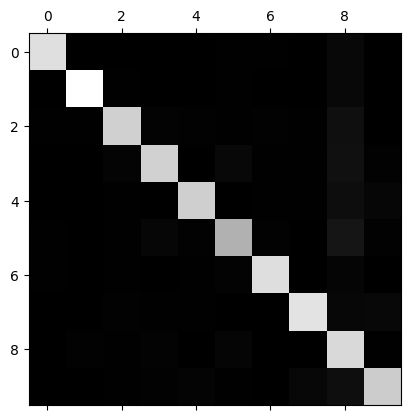

In [65]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

* 대부분의 이미지가 올바르게 분류되었음을 나타내는 주대각선에 있으므로 매우 좋음
* 숫자 5가 다른 숫자보다 조금 더 어두워 보이는데, 이는 데이터셋에 숫자 5의 이미지가 적거나 분류기가 숫자 5를 다른 숫자만큼 잘 분류하지 못한다는 뜻  

그래프의 에러 부분에 초점을 맞춰보기
* 오차 행렬의 각 값을 대응되는 클래스의 이미지 개수로 나누어 에러 '비율'을 비교(개수로 비교하면 이미지가 많은 클래스가 상대적으로 나쁘게 보임)

In [66]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

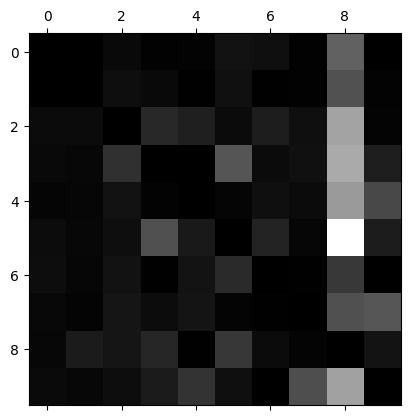

In [67]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

* 클래스 8의 열이 상당히 밝으므로 많은 이미지가 8로 잘못 분류되었음을 암시
* 하지만 클래스 8의 행은 그리 나쁘지 않으므로 실제 8이 적절히 8로 분류되었다는 것을 말해줌
* 8로 잘못 분류된 숫자의 훈련 데이터를 더 많이 모아서 실제 8과 구분하도록 분류기를 학습시킬 수 있음
* 3과 5도 서로 많이 혼동되고 있음

In [69]:
def plot_digits(instances, images_per_row=10, **options):
  size = 28
  images_per_row = min(len(instances), images_per_row)
  images = [instance.reshape(size,size) for instance in instances]
  n_rows = (len(instances) - 1) // images_per_row + 1
  row_images = []
  n_empty = n_rows * images_per_row - len(instances)
  images.append(np.zeros((size, size * n_empty)))
  for row in range(n_rows):
    rimages = images[row * images_per_row : (row + 1) * images_per_row]
    row_images.append(np.concatenate(rimages, axis=1))
  image = np.concatenate(row_images, axis=0)
  plt.imshow(image, cmap = plt.cm.binary, **options)
  plt.axis("off")

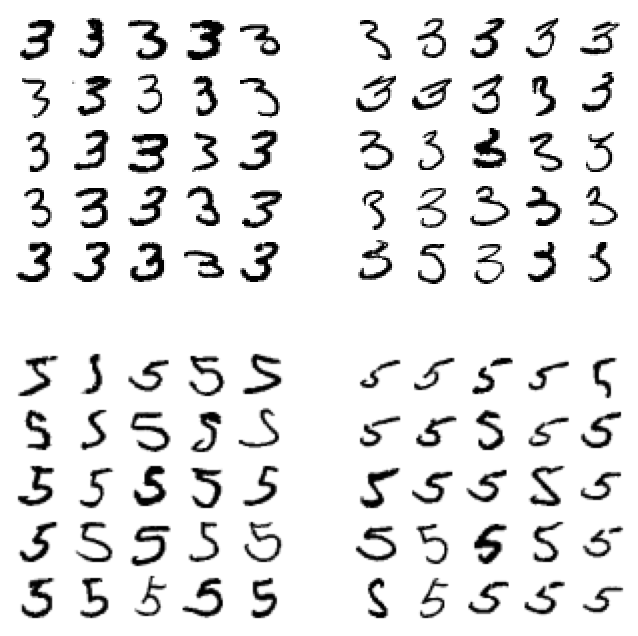

In [70]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train==cl_a)&(y_train_pred==cl_a)]
X_ab = X_train[(y_train==cl_a)&(y_train_pred==cl_b)]
X_ba = X_train[(y_train==cl_b)&(y_train_pred==cl_a)]
X_bb = X_train[(y_train==cl_b)&(y_train_pred==cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

* 왼쪽 블록 두 개는 3으로 분류된 이미지, 오른쪽 블록 두 개는 5로 분류된 이미지
* 원인은 SGD 분류기를 사용했기 때문, 선형 분류기는 클래스마다 픽셀에 가중치를 할당하고 새로운 이미지에 대해 단순히 픽셀 강도의 가중치 합을 클래스의 점수로 계산함
* 3과 5는 몇 개의 픽셀만 다르기 때문에 모델이 쉽게 혼동하게 됨

3과 5의 에러를 줄이는 한 가지 방법은 이미지를 중앙에 위치시키고 회전되어 있지 않도록 전처리

### 3.6 다중 레이블 분류
예를 들어 같은 사진에 여러 사람이 등장한다면 인식된 사람마다 하나씩 꼬리표를 붙여야함  
여러 개의 이진 꼬리표를 출력하는 분류 시스템

In [71]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train%2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

* 이 코드는 각 숫자 이미지에 두 개의 타깃 레이블이 담긴 y_multilabel 배열을 만듬, 첫 번째는 숫자가 큰 값인지 나타내고 두 번째는 홀수인지 나타냄, 그리고 다중 타깃 배열을 사용하여 훈련시킴

In [72]:
knn_clf.predict([some_digit])

array([[False,  True]])

* 올바르게 분류됨 (숫자 5는 크지 않고 홀수임)
* 다중 레이블 분류기를 평가하는 방법은 많지만 예시로 각 레이블의 F1 점수를 구하고 간단하게 평균 점수를 계산
* 다음은 모든 레이블에 대한 F1 점수의 평균을 계산

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train.y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average='macro')

* 이 코드는 모든 레이블의 가중치가 같다고 가정한 것
* 레이블에 클래스의 지지도(즉, 타깃 레이블에 속한 샘플 수)를 가중치로 주려면 average='weighted'로 설정하면 됨

### 3.7 다중 출력 분류
다중 레이블 분류에서 한 레이블이 다중 클래스가 될 수 있도록 일반화 한 것

* 먼저 MNIST 이미지에서 추출한 훈련 세트와 테스트 세트에 픽셀 강도에 잡음을 추가

In [73]:
noise = np.random.randint(0,100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0,100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

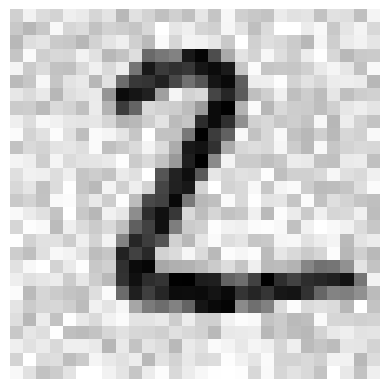

In [78]:
plot_digits([X_test_mod[1]])

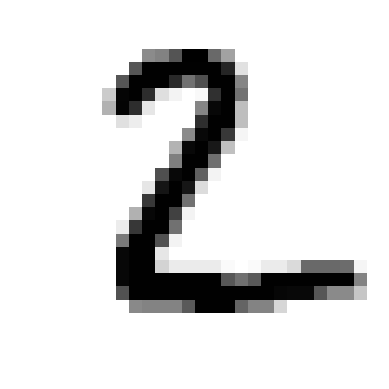

In [77]:
plot_digits([X_test[1]])

* 위가 입력 이미지, 아래가 타깃 이미지, 분류기를 훈련시켜 이 이미지를 깨끗하게 만들어봄

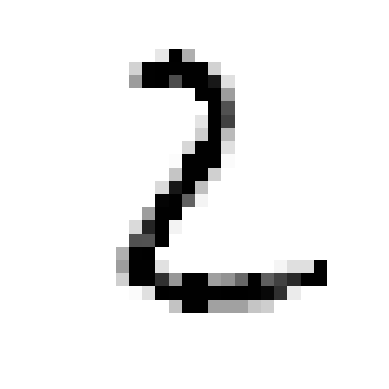

In [76]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[1]])
plot_digits(clean_digit)